In [42]:
import geopandas as gpd
import pandas as pd 
from sklearn import preprocessing 
from tqdm import tqdm
import networkx as nx
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import numpy as np
import math
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from modularity_maximization import partition
from modularity_maximization.utils import get_modularity
from modutils import mod_calc
device = torch.device('cpu')
import evaluation

## graph construction

In [263]:
sample_num = 500

In [264]:
# 确认节点数量
bs_gpd = gpd.read_file('../../data/basestation-gis/basestation_aggregation.shp')
bs_gpd = bs_gpd.iloc[:sample_num:, ::]
bs_num = bs_gpd.shape[0]

In [265]:
# 构造图节点
nodes_list = list(range(bs_num))
G = nx.Graph()
G.add_nodes_from(nodes_list)

In [266]:
# 读取邻接矩阵adjacent
# 以工作日(周一)的早高峰时段为例
adj = pd.read_csv('../../data/adj/adj_20151109_0002.csv')
adj = adj.iloc[:, 1:].values
adj = adj[:sample_num:, :sample_num:]
adj = adj + adj.T
for i in range(sample_num): adj[i, i] = 0

In [267]:
for i in range(bs_num):
    if (adj[i]==0).all():
        adj[i, :] = 0.0001
        adj[:, i] = 0.0001

In [268]:
for i in tqdm(range(bs_num)):
    for j in range(bs_num):
        tmp = adj[i, j]
        if tmp>0: G.add_edge(i, j, weight=tmp)

100%|██████████| 500/500 [00:00<00:00, 1988.98it/s]


1. 带边权的图，自己生成。 √  
2. 要检查一下modualrity的计算是不是一般意义上的，要改正。 √  
3. 看看HARATE CLUB，开发其他可用算法。 √ 
3. 看懂gumbel_softmax过程，实现RAE。  
4. 接着再实现SBM。  
5. 看所有方法的结果，找最好的improve成自己的目标函数，在real-world data上测试。

## partition process

In [156]:
# Newman: spectral methods
comm_dict = partition(G)
clusters_number = len(np.array(list(set(comm_dict.values()))))

In [297]:
evaluation.modularity(G, list(comm_dict.values()))

0.4830532646002295

In [314]:
clusters_number

5

In [159]:
A_hat = nx.adjacency_matrix(G).todense() # a matrix: A
X = np.identity(G.number_of_nodes(), dtype=np.float)  

np.identity()只能创建方阵，np.eye()可以创建一般矩阵，主对角线为1，其余元素为0。

In [216]:
torch.div(aa, aa.sum(axis=0))

tensor([[0.5000, 0.3333, 0.2500, 0.2000],
        [0.5000, 0.6667, 0.7500, 0.8000]])

In [217]:
m = nn.Softmax(dim=0)
m(aa)

tensor([[0.5000, 0.2689, 0.1192, 0.0474],
        [0.5000, 0.7311, 0.8808, 0.9526]])

In [218]:
m = nn.Softmax(dim=0)
m(torch.div(aa, aa.sum(axis=0)))

tensor([[0.5000, 0.4174, 0.3775, 0.3543],
        [0.5000, 0.5826, 0.6225, 0.6457]])

In [198]:
class CDCGS(nn.Module):
    def __init__(self, A_hat, num_feat, num_hidden):
        super(CDCGS, self).__init__()
        self.num_feat = num_feat # 特征数 f
        self.num_hidden = num_hidden # 隐含数 h
        self.A_hat = A_hat
        self.W_0 = nn.Parameter(torch.ones(num_feat, num_hidden)) # [1][f*h]
        # random.sample(range(0, num_feat), num_feat)可用实现不放回抽样，用于随机排序。
        random_feat = random.sample(range(0, num_feat), num_feat)
        # 将每个sample出的数值编码为一个onehot，作为I的一行。
        I = F.one_hot(torch.tensor(random_feat), num_classes=num_feat)
        self.I = torch.tensor(I, dtype=torch.float)

    def forward(self, X, A_hat,temp): # X貌似暂时没有用到
        global featureSelector # 
        global weight_feature # 
        featureSelector = self.W_0 # [1][f*h]
        results = torch.zeros(self.W_0.size()) # [0][f*h]
        x = 500 # x次取平均,目测这个目的是为了稳定。
        for i in range(x):
            # logits --> self.W_0: [batch_size, num_features] 非规范化对数概率
            # tau: 非负的对抗强度。
            # hard: 如果 True, 返回的样本将会离散为 one-hot 向量
            results += F.gumbel_softmax(self.W_0,tau=temp,hard=False)
        weight_feature = results/x # [-][f*h]

        # H = torch.mm(torch.mm(self.I,A_hat),self.I.T)
        H = torch.mm(torch.mm(weight_feature.T,A_hat),weight_feature) # weight_feature 就是我们要求的U
        H = torch.div(H, H.sum(axis=0)) # 按照每一列进行归一化，列为axis=0的方向。
        m = nn.Softmax(dim=0)
        return m(H)
    
def lossFn(output): 
    return torch.sum((torch.diag(-torch.log(output))))

In [293]:
num_feat = len(G.nodes()) # f = 节点数
num_hidden = clusters_number # h = 聚类数

model = CDCGS(A_hat, num_feat, num_hidden).to(device)

optimizer = optim.Adam(model.parameters(),lr=1e-2,weight_decay=0,betas=(0.5, 0.999), eps=1e-08)


A_hat_tensor = torch.Tensor(A_hat).to(device)
X_tensor = torch.Tensor(X).to(device)

loss_hist = []
acc_hist = []
temp = 3

for epoch in range(500):
    model.train()
    model.zero_grad()
    if(epoch == 75):
        temp = 2.75
    elif(epoch == 100):
        temp = 2.5
    elif(epoch == 125):
        temp = 2
    elif(epoch == 150):
        temp = 1.8
    elif(epoch == 175):
        temp = 1.25
    elif(epoch == 250):
        temp = 1.00
    elif(epoch == 300):
        temp = 0.75
    elif(epoch == 320):
        temp = 0.50
    elif(epoch == 400):
        temp = 0.2
    output = model(X_tensor, A_hat_tensor, temp)
    loss = lossFn(output)
    loss_hist.append(loss.item())
    if epoch%10==0: 
        print('loss',epoch,loss)
    loss.backward()
    optimizer.step()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':


loss 0 tensor(8.0472, grad_fn=<SumBackward0>)
loss 10 tensor(8.0470, grad_fn=<SumBackward0>)
loss 20 tensor(8.0449, grad_fn=<SumBackward0>)
loss 30 tensor(8.0393, grad_fn=<SumBackward0>)
loss 40 tensor(8.0296, grad_fn=<SumBackward0>)
loss 50 tensor(8.0165, grad_fn=<SumBackward0>)
loss 60 tensor(8.0003, grad_fn=<SumBackward0>)
loss 70 tensor(7.9798, grad_fn=<SumBackward0>)
loss 80 tensor(7.9426, grad_fn=<SumBackward0>)
loss 90 tensor(7.9104, grad_fn=<SumBackward0>)
loss 100 tensor(7.8471, grad_fn=<SumBackward0>)
loss 110 tensor(7.8013, grad_fn=<SumBackward0>)
loss 120 tensor(7.7565, grad_fn=<SumBackward0>)
loss 130 tensor(7.5821, grad_fn=<SumBackward0>)
loss 140 tensor(7.5044, grad_fn=<SumBackward0>)
loss 150 tensor(7.3563, grad_fn=<SumBackward0>)
loss 160 tensor(7.2672, grad_fn=<SumBackward0>)
loss 170 tensor(7.1762, grad_fn=<SumBackward0>)
loss 180 tensor(6.7915, grad_fn=<SumBackward0>)
loss 190 tensor(6.6636, grad_fn=<SumBackward0>)
loss 200 tensor(6.5545, grad_fn=<SumBackward0>)
los

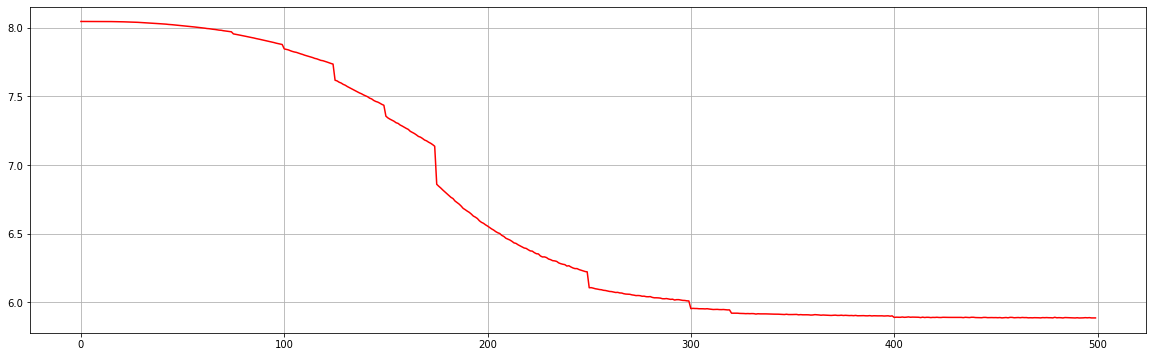

In [294]:
plt.figure(figsize=(20, 6))
plt.plot(loss_hist, color='red')
plt.grid(True)
plt.show()

In [295]:
print(weight_feature.detach().size())
gumbel_matrix = weight_feature.detach().max(dim=1)[1] # 每个节点的标签组成的tensor
labels_pred = gumbel_matrix.data.numpy()

torch.Size([500, 5])


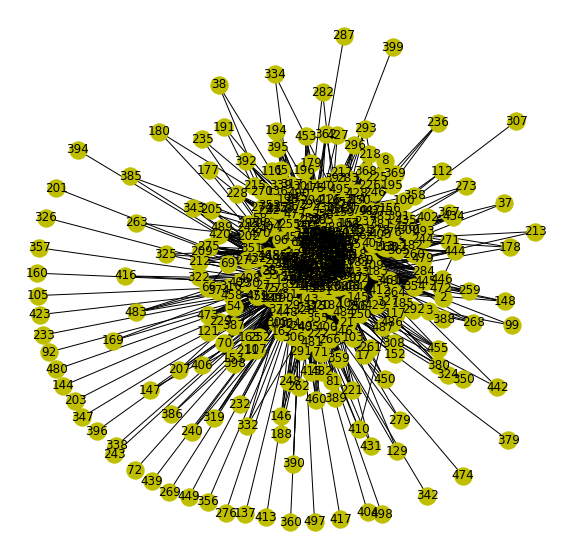

Modularity is 0.65839


<Figure size 864x864 with 0 Axes>

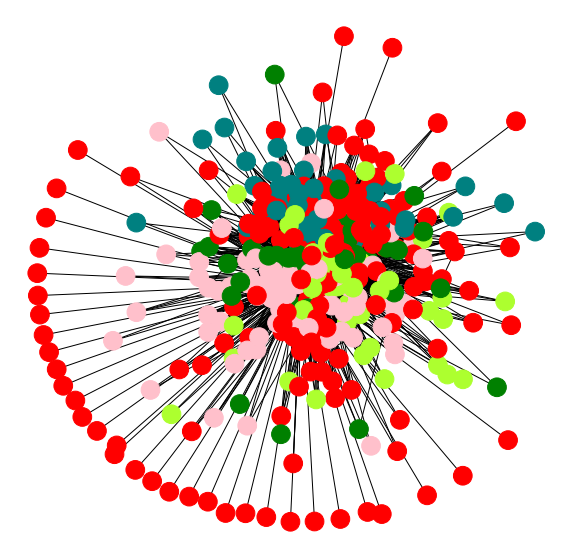

In [296]:
pos = nx.spring_layout(G)
plt.figure(figsize=(10, 10))
plt.axis('off')
nx.draw_networkx(G, pos=pos, node_size=300, node_color="y", with_labels=True)
options = {
    'node_color': 'red',
    'node_size': 50,
    'line_color': 'grey',
    'linewidths': 0,
    'width': 0.1,
}
plt.show()

print('Modularity is %.5f' %evaluation.modularity(G, labels_pred))
color = []
for c in range(len(gumbel_matrix)):
    if(gumbel_matrix[c] == 0):
        color.append('r')
    elif(gumbel_matrix[c] == 1):
        color.append('g')
    elif(gumbel_matrix[c] == 2):
        color.append('teal')
    elif(gumbel_matrix[c] == 3):
        color.append('greenyellow')
    elif(gumbel_matrix[c] == 4):
        color.append('pink')
    elif(gumbel_matrix[c] == 5):
        color.append('dimgrey')
    elif(gumbel_matrix[c] == 6):
        color.append('peachpuff')
    elif(gumbel_matrix[c] == 7):
        color.append('gold')
    elif(gumbel_matrix[c] == 8):
        color.append('m')
    elif(gumbel_matrix[c] == 9):
        color.append('aqua')
    elif(gumbel_matrix[c] == 10):
        color.append('indianred')
    elif(gumbel_matrix[c] == 11):
        color.append('sienna')
plt.figure(figsize=(12, 12))
options = {
    'node_color': color,
    'node_size': 50,
    'line_color': 'grey',
    'linewidths': 0,
    'width': 0.1,
}
plt.figure(figsize=(10, 10))
plt.axis('off')
nx.draw_networkx(G, pos=pos, node_size=150, node_color=color, with_labels=False)
plt.show()

## baselines

In [269]:
import networkx as nx
from karateclub import EgoNetSplitter, DANMF, NNSED, MNMF, BigClam, SymmNMF
from karateclub import GEMSEC, EdMot, SCD, LabelPropagation
from tkinter import _flatten

**Overlapping**

In [303]:
model1 = EgoNetSplitter(weight='weight')
model1.fit(G)
cluster_membership1 = model1.get_memberships()
clusters1 = cluster_membership1
labels_pred1 = list(clusters1.values())
print('Modularity of such partition for MNMF is %.6f' %evaluation.modularity(G, list(_flatten(labels_pred1))))

Modularity of such partition for MNMF is 0.092590


In [304]:
model2 = DANMF(layers=[32, clusters_number])
# model2 = DANMF(layers=[32, 3])
model2.fit(G)
cluster_membership2 = model2.get_memberships()
clusters2 = cluster_membership2
labels_pred2 = list(clusters2.values())
print('Modularity of such partition for DANMF is %.6f' %evaluation.modularity(G, list(_flatten(labels_pred2))))

Modularity of such partition for DANMF is 0.814536


In [306]:
model3 = NNSED(dimensions=clusters_number)
model3.fit(G)
cluster_membership3 = model3.get_memberships()
clusters3 = cluster_membership3
labels_pred3 = list(clusters3.values())
print('Modularity of such partition for NNSED is %.6f' %evaluation.modularity(G, list(_flatten(labels_pred3))))

Modularity of such partition for NNSED is 0.455298


In [307]:
model4 = MNMF(clusters=clusters_number, iterations=200)
model4.fit(G)
cluster_membership4 = model4.get_memberships()
clusters4 = cluster_membership4
labels_pred4 = list(clusters4.values())
print('Modularity of such partition for MNMF is %.6f' %evaluation.modularity(G, list(_flatten(labels_pred4))))

Modularity of such partition for MNMF is 0.679078


In [308]:
model5 = BigClam(dimensions=clusters_number, iterations=50)
model5.fit(G)
cluster_membership5 = model5.get_memberships()
clusters5 = cluster_membership5
labels_pred5 = list(clusters5.values())
print('Modularity of such partition for BigClam is %.6f' %evaluation.modularity(G, list(_flatten(labels_pred5))))

Modularity of such partition for BigClam is 0.891823


In [309]:
model6 = SymmNMF(dimensions=clusters_number)
model6.fit(G)
cluster_membership6 = model6.get_memberships()
clusters6 = cluster_membership6
labels_pred6 = list(clusters6.values())
print('Modularity of such partition for SymmNMF is %.6f' %evaluation.modularity(G, list(_flatten(labels_pred6))))

Modularity of such partition for SymmNMF is 0.607394


**Non-overlapping**

In [310]:
model7 = GEMSEC(clusters=clusters_number)
model7.fit(G)
cluster_membership7 = model7.get_memberships()
clusters7 = cluster_membership7
labels_pred7 = list(clusters7.values())
print('Modularity of such partition for GEMSEC is %.6f' %evaluation.modularity(G, list(_flatten(labels_pred7))))

Modularity of such partition for GEMSEC is 0.231795


In [311]:
model8 = EdMot()
model8.fit(G)
cluster_membership8 = model8.get_memberships()
clusters8 = cluster_membership8
labels_pred8 = list(clusters8.values())

print('Modularity of such partition for EdMot is %.6f' %evaluation.modularity(G, list(_flatten(labels_pred8))))

Modularity of such partition for EdMot is 0.630994


In [312]:
model9 = SCD()
model9.fit(G)
cluster_membership9 = model9.get_memberships()
clusters9 = cluster_membership9
labels_pred9 = list(clusters9.values())
print('Modularity of such partition for SCD is %.6f' %evaluation.modularity(G, list(_flatten(labels_pred9))))

Modularity of such partition for SCD is 0.767430


In [313]:
model10 = LabelPropagation()
model10.fit(G)
cluster_membership10 = model10.get_memberships()
clusters10 = cluster_membership10
labels_pred10 = list(clusters10.values())
print('Modularity of such partition for LabelPropagation is %.6f' %evaluation.modularity(G, list(_flatten(labels_pred10))))

Modularity of such partition for LabelPropagation is 0.966575
